In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
import seaborn as sns
from skimage.filters import prewitt_h
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import heatmap
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
import scipy.stats as stats
import pickle
import os
import time
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

directory = 'pkl_objects'

# plt.style.use('dark_background')

In [2]:
df_train = pd.read_csv('MNIST_CSV/mnist_train.csv', header=None)
df_test = pd.read_csv('MNIST_CSV/mnist_test.csv', header=None)
df_train

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = df_train[0].to_numpy()
y_test = df_test[0].to_numpy()
x_train = df_train.iloc[:, 1:785].to_numpy()
x_test = df_test.iloc[:, 1:785].to_numpy()

#observing class label distribution
print(np.bincount(y_train))
print(np.bincount(y_test))

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
[ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [5]:
x_train_img = np.reshape(x_train, (60000, 28, 28))
x_test_img = np.reshape(x_test, (10000, 28, 28))

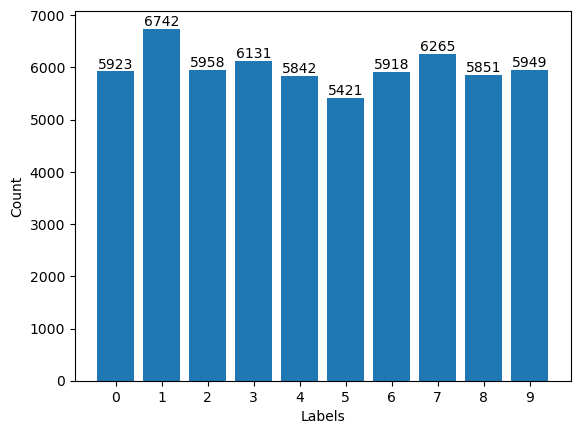

In [6]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)

plt.bar(unique_labels, label_counts)

for i, count in enumerate(label_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(range(len(unique_labels)), unique_labels)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.savefig('Images/train_set_distn.png')
plt.show()

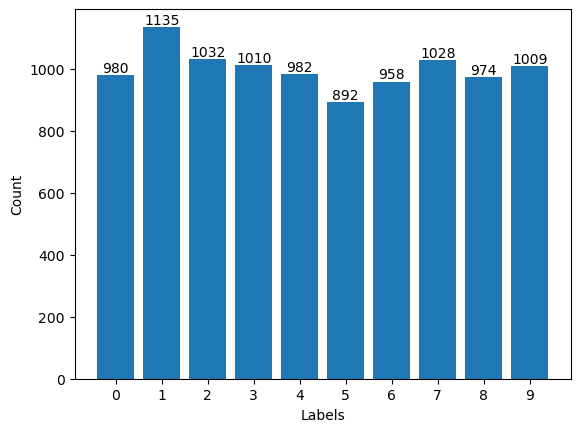

In [7]:
unique_labels, label_counts = np.unique(y_test, return_counts=True)

plt.bar(unique_labels, label_counts)

for i, count in enumerate(label_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(range(len(unique_labels)), unique_labels)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.savefig('Images/test_set_distn.png')
plt.show()

In [8]:
#displaying 2 images from each label in training dataset
idx = {}
labels = np.unique(y_train)

for i, val in enumerate(y_train):
    if val not in idx:
        idx[val] = [i]
    else:
        if len(idx[val]) == 2:
            continue
        idx[val].append(i)

idx = dict(sorted(idx.items()))
idx

In [9]:
idx_list = []
for i in idx:
    idx_list.extend(idx[i])

fig, axes = plt.subplots(5, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_img[idx_list[i]], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig('Images/training_2numbers_eachlabel.png')
plt.show()

In [10]:
#scaling the dataset
sc = StandardScaler()
x_train_mean = sc.fit_transform(x_train)
x_test_mean = sc.fit_transform(x_test)

# path = os.path.join(directory, 'standardscaler_originaldata.pkl')

# with open(path, 'wb') as file:
#     pickle.dump(sc, file)

459


In [ ]:
#performing PCA
pca = PCA(n_components=0.98)
x_train_pca = pca.fit_transform(x_train_mean, y_train)
x_test_pca = pca.transform(x_test_mean)
print(pca.n_components_)

In [11]:
#performing LDA
lda = LinearDiscriminantAnalysis()
x_train_lda = lda.fit_transform(x_train_mean, y_train)
x_test_lda = lda.transform(x_test_mean)

<h3>The next cell has the custom feature extractor that we implemented</h3>

In [12]:
def custom_transform(x, scale):
    new_x = np.empty(x.shape, dtype=(np.float32))
    for i in range(x.shape[0]):
        temp = np.copy(x[i]).astype(np.float32)
        temp[(temp > 0) & (temp < 200)] = scale
        temp[temp >= 200] = 1
        new_x[i][:][:] = temp.astype(np.float32)

    return new_x

In [13]:
x_train_to_one = custom_transform(x_train_img, 0.75).reshape(-1, 784)
x_test_to_one = custom_transform(x_test_img, 0.75).reshape(-1, 784)

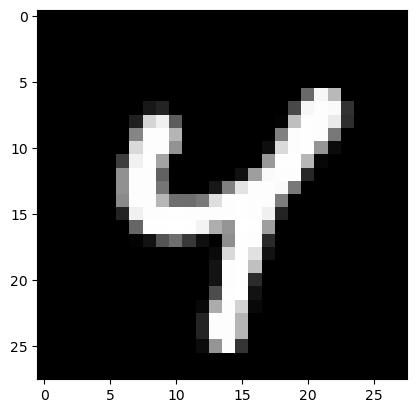

In [14]:
plt.imshow(x_train_img[1008], cmap='gray')
plt.savefig('Images/1008_training_img.png')
plt.show()

<h3>Visualising the custom transformed image as a scatter plot</h3>

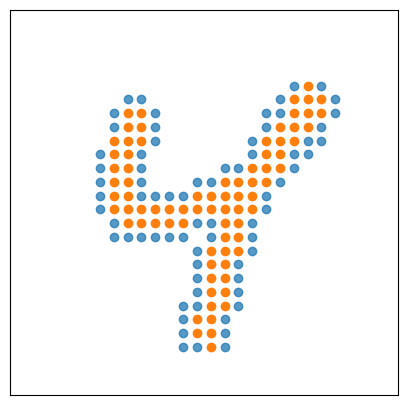

In [15]:
arr = x_train_to_one[1008].reshape(28, 28)
indices_point75 = np.argwhere(arr == 0.75)
indices_1 = np.argwhere(arr == 1)

x_grid, y_grid = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))

plt.figure(figsize=(5, 5))
plt.scatter(x_grid, y_grid, c='white', marker='s', alpha=0)
plt.scatter(indices_point75[:, 1], 28 - indices_point75[:, 0], marker='o', alpha=0.75)
plt.scatter(indices_1[:, 1], 28 - indices_1[:, 0], marker='o', alpha=1)
plt.xlim(-0.5, arr.shape[1] - 0.5)
plt.ylim(-0.5, arr.shape[0] - 0.5)
plt.xticks([])
plt.yticks([])
plt.savefig('Images/1008_custom_training_img.png')
plt.show()

<h3>Using prewitt kernel for horizontal edge detection</h3>

In [16]:
train_prewitt = np.empty((x_train.shape[0], 784))
test_prewitt = np.empty((x_test.shape[0], 784))

for i in range(x_train.shape[0]):
    img = prewitt_h(x_train[i].reshape(28, 28))
    train_prewitt[i][:] = img.reshape(-1)

for i in range(x_test.shape[0]):
    img = prewitt_h(x_test[i].reshape(28, 28))
    test_prewitt[i][:] = img.reshape(-1)

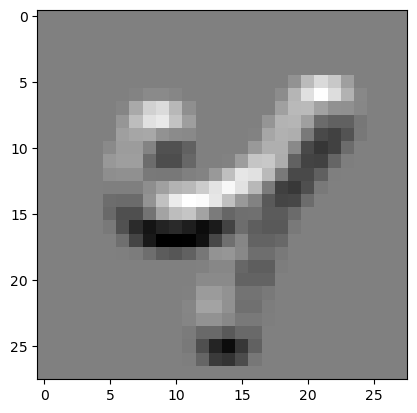

In [17]:
plt.imshow(train_prewitt[1008].reshape(28, 28), cmap='gray')
plt.savefig('Images/1008_edge_detector.png')
plt.show()

<h3>Function to plot confusion matrices</h3>

In [18]:
def plot_conf_matrix(y_test, y_pred, clf):
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax)

<h3><b>Using KNN</b></h3>

In [77]:
#with scaled data
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn.fit(x_train_mean, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [78]:
print(knn.score(x_train_mean, y_train))
y_pred = knn.predict(x_test_mean)
print(accuracy_score(y_test, y_pred))

0.9727666666666667
0.9441


In [61]:
# path = os.path.join(directory, 'knn_standardscaler.pkl')

# with open(path, 'wb') as file:
#     pickle.dump(knn, file)

In [79]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.95      0.99      0.97      1135
           2       0.95      0.94      0.95      1032
           3       0.93      0.95      0.94      1010
           4       0.95      0.94      0.94       982
           5       0.93      0.93      0.93       892
           6       0.97      0.96      0.97       958
           7       0.93      0.93      0.93      1028
           8       0.96      0.90      0.93       974
           9       0.93      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



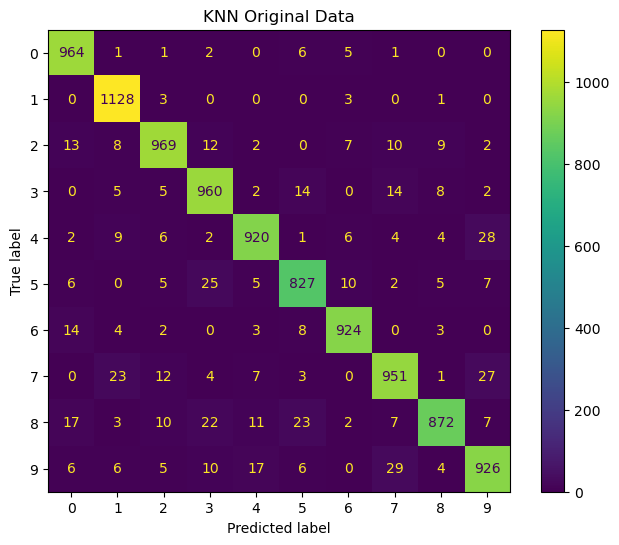

In [80]:
plot_conf_matrix(y_test, y_pred, knn)
plt.title('KNN Original Data')
plt.savefig('Images/cm_knn_orig.png')
plt.show()

In [81]:
#with edge detector data
knn_edge = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_edge.fit(train_prewitt, y_train)

print(knn_edge.score(train_prewitt, y_train))
y_pred = knn_edge.predict(test_prewitt)
print(accuracy_score(y_test, y_pred))

0.9733
0.9468


In [82]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       980
           1       0.91      1.00      0.95      1135
           2       0.98      0.91      0.95      1032
           3       0.93      0.92      0.93      1010
           4       0.96      0.98      0.97       982
           5       0.97      0.89      0.93       892
           6       0.97      0.97      0.97       958
           7       0.94      0.97      0.96      1028
           8       0.96      0.89      0.92       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



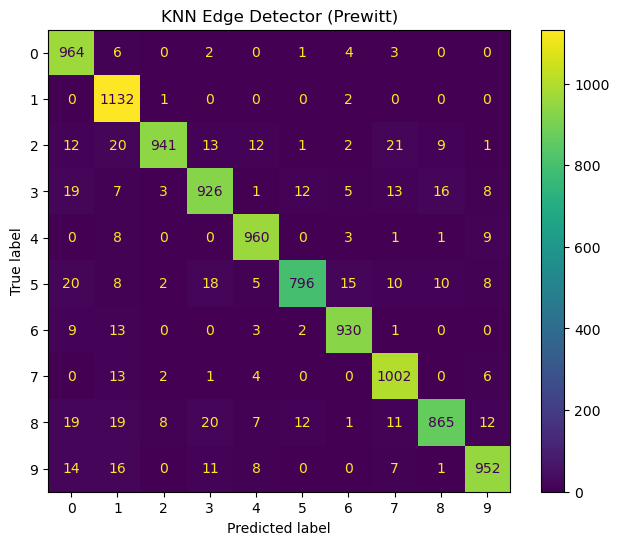

In [83]:
plot_conf_matrix(y_test, y_pred, knn_edge)
plt.title('KNN Edge Detector (Prewitt)')
plt.savefig('Images/cm_knn_edge.png')
plt.show()

In [84]:
#with custom transformed data
knn_custom = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_custom.fit(x_train_to_one, y_train)

print(knn_custom.score(x_train_to_one, y_train))
y_pred = knn_custom.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

0.9855166666666667
0.9672


In [85]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.95      0.96       982
           5       0.97      0.95      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



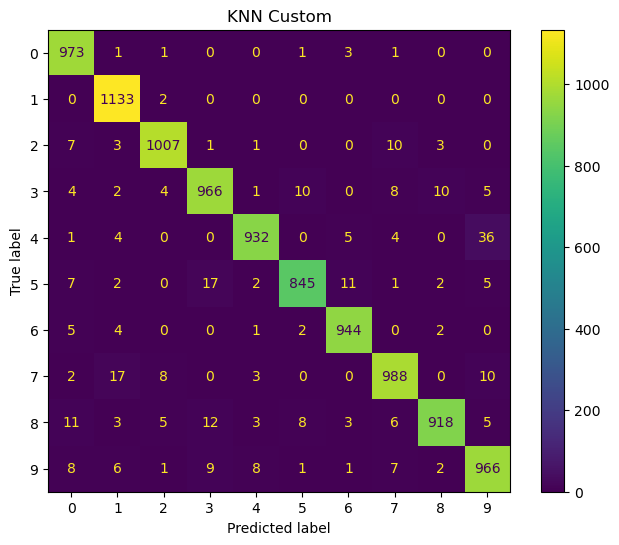

In [86]:
plot_conf_matrix(y_test, y_pred, knn_custom)
plt.title('KNN Custom')
plt.savefig('Images/cm_knn_custom.png')
plt.show()

In [87]:
# path = os.path.join(directory, 'knn_edgedetection.pkl')

# with open(path, 'wb') as file:
#     pickle.dump(knn_edge, file)

<h3>Correlation matrix of PCA transformed data</h3>

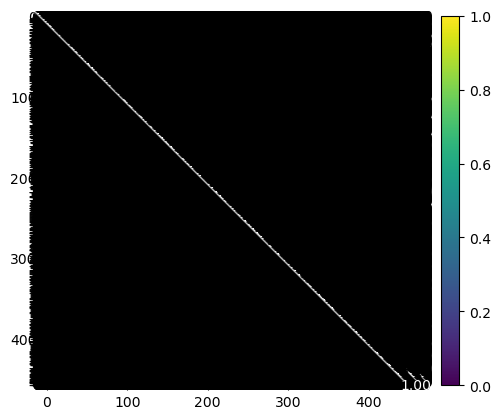

In [88]:
corr = np.corrcoef(x_train_pca, rowvar=False)
heatmap(corr)
plt.savefig('corr_matrix_pca.png')
plt.show()

<h3><b>Using Decision Trees</b></h3>

In [89]:
#with PCA transformed data
dt = DecisionTreeClassifier()
dt.fit(x_train_pca, y_train)

print(dt.score(x_train_pca, y_train))
print(dt.score(x_test_pca, y_test))

1.0
0.8215


In [63]:
print(dt.get_depth())

# path = os.path.join(directory, 'dt_max_depth_none.pkl')

# with open(path, 'wb') as file:
#     pickle.dump(dt, file)

55


In [54]:
#performing Grid Search to find optimum max depth for PCA transformed data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
model = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(10, 30)
}

gcv = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   scoring='accuracy',
                   n_jobs=-1,
                   refit=True,
                   cv=cv,
                   return_train_score=True)

gcv.fit(x_train_pca, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(10, 30)}, return_train_score=True,
             scoring='accuracy')

In [64]:
print(gcv.best_params_)
dt_best = gcv.best_estimator_
print(dt_best.score(x_train_pca, y_train))
print(dt_best.score(x_test_pca, y_test))

# path = os.path.join(directory, 'dt_gcv_best.pkl')

# with open(path, 'wb') as file:
#     pickle.dump(dt_best, file)

{'max_depth': 14}
0.9442
0.8344


In [90]:
dt_pca = DecisionTreeClassifier(max_depth=14)
dt_pca.fit(x_train_pca, y_train)

print(dt_pca.score(x_train_pca, y_train))
y_pred = dt_pca.predict(x_test_pca)
print(accuracy_score(y_test, y_pred))

0.9442333333333334
0.8333


In [91]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       980
           1       0.95      0.96      0.96      1135
           2       0.82      0.81      0.81      1032
           3       0.76      0.80      0.78      1010
           4       0.81      0.81      0.81       982
           5       0.78      0.78      0.78       892
           6       0.91      0.89      0.90       958
           7       0.85      0.84      0.84      1028
           8       0.77      0.75      0.76       974
           9       0.77      0.79      0.78      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



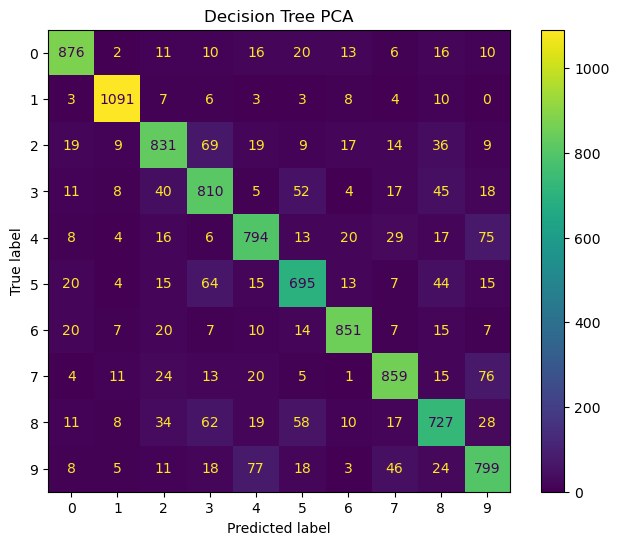

In [92]:
plot_conf_matrix(y_test, y_pred, dt_pca)
plt.title('Decision Tree PCA')
plt.savefig('Images/cm_dt_pca.png')
plt.show()

In [16]:
#performing Grid Search for custom transformed data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
model = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(10, 20)
}

gcv = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   scoring='accuracy',
                   n_jobs=12,
                   refit=True,
                   cv=cv,
                   return_train_score=True)

gcv.fit(x_train_to_one, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=12,
             param_grid={'max_depth': range(10, 20)}, return_train_score=True,
             scoring='accuracy')

In [18]:
print(gcv.best_params_)
dt_best = gcv.best_estimator_
print(dt_best.score(x_train_to_one, y_train))
print(dt_best.score(x_test_to_one, y_test))

{'max_depth': 17}
0.9888833333333333
0.8889


In [93]:
#with custom transformed data
dt_custom = DecisionTreeClassifier(max_depth=17)
dt_custom.fit(x_train_to_one, y_train)

print(dt_custom.score(x_train_to_one, y_train))
y_pred = dt_custom.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

0.9889
0.8917


In [94]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.93      0.97      0.95      1135
           2       0.88      0.86      0.87      1032
           3       0.86      0.85      0.85      1010
           4       0.91      0.89      0.90       982
           5       0.86      0.85      0.85       892
           6       0.92      0.91      0.92       958
           7       0.91      0.91      0.91      1028
           8       0.85      0.83      0.84       974
           9       0.85      0.89      0.87      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



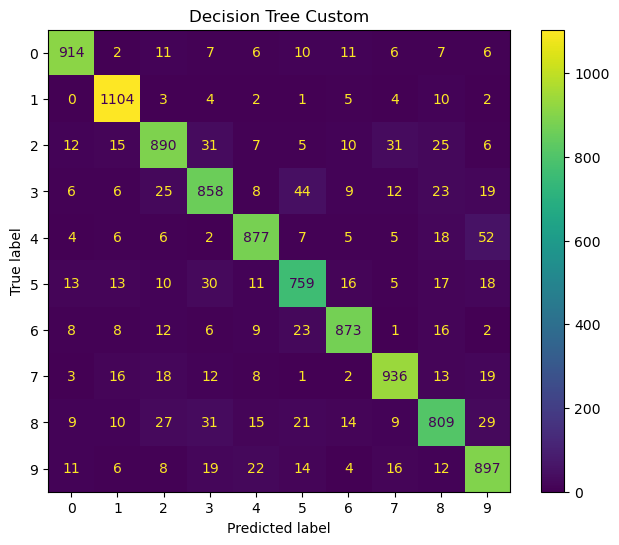

In [95]:
plot_conf_matrix(y_test, y_pred, dt_custom)
plt.title('Decision Tree Custom')
plt.savefig('Images/cm_dt_custom.png')
plt.show()

<h3>Accuracy vs max depth for custom transformed data</h3>

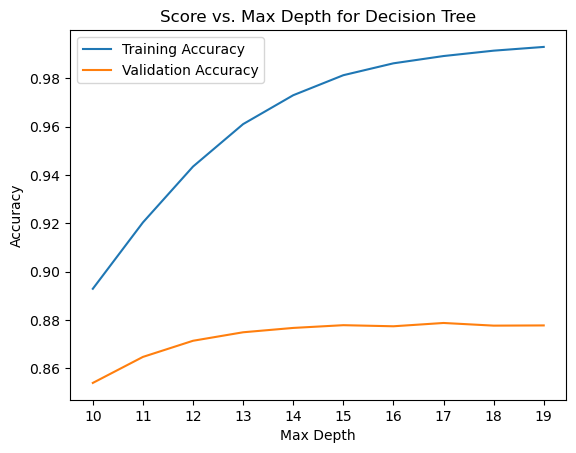

In [21]:
#Clear overfitting as max depth increases. Validation accuracy remains similar
plt.plot(range(10, 20), gcv.cv_results_['mean_train_score'], label='Training Accuracy')
plt.plot(range(10, 20), gcv.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Score vs. Max Depth for Decision Tree')
plt.legend()
plt.xticks(range(10, 20))
plt.savefig('Images/score vs max depth.png')
plt.show()

<h3>Accuracy vs max depth for PCA transformed data</h3>

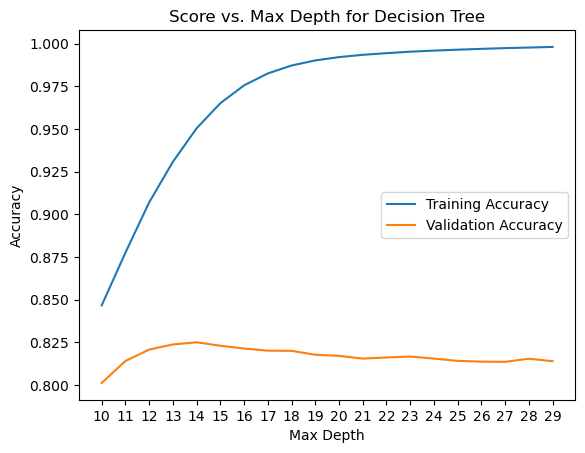

In [66]:
#Clear overfitting as max depth increases. Validation accuracy remains similar
plt.plot(range(10, 30), gcv.cv_results_['mean_train_score'], label='Training Accuracy')
plt.plot(range(10, 30), gcv.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Score vs. Max Depth for Decision Tree')
plt.legend()
plt.xticks(range(10, 30))
plt.savefig('Images/score vs max depth.png')
plt.show()

In [145]:
#with original data
dt_orig_data = DecisionTreeClassifier(max_depth=14)
dt_orig_data.fit(x_train, y_train)
print(dt_orig_data.score(x_train, y_train))
print(dt_orig_data.score(x_test, y_test))


0.9769333333333333
0.8822


<h3><b>Using Logistic Regression</b></h3>

In [96]:
#with original data
lr = LogisticRegression(n_jobs=-1, C=0.01)
lr.fit(x_train_mean, y_train)

print(lr.score(x_train_mean, y_train))
y_pred = lr.predict(x_test_mean)
print(accuracy_score(y_test, y_pred))

0.9360333333333334
0.9258


In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.94      0.94       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.88      0.89      0.88       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



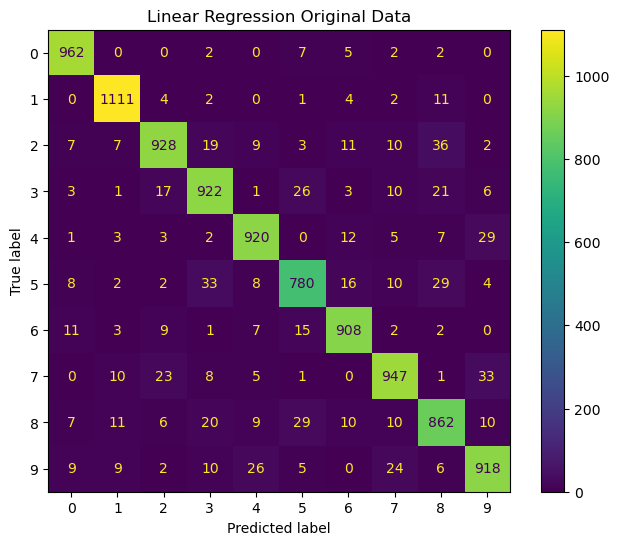

In [98]:
plot_conf_matrix(y_test, y_pred, lr)
plt.title('Linear Regression Original Data')
plt.savefig('Images/cm_lr_orig.png')
plt.show()

In [99]:
#poor results on edge detector data
lr = LogisticRegression(n_jobs=-1)
lr.fit(train_prewitt, y_train)

print(lr.score(train_prewitt, y_train))
print(lr.score(test_prewitt, y_test))

0.11236666666666667
0.1135


In [100]:
#PCA transformed data
lr = LogisticRegression(n_jobs=-1, multi_class='multinomial')
lr.fit(x_train_pca, y_train)

print(lr.score(x_train_pca, y_train))
y_pred = lr.predict(x_test_pca)
print(accuracy_score(y_test, y_pred))

0.9376666666666666
0.925


In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.89      0.88      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.89      0.88      0.88       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.93      0.92     10000



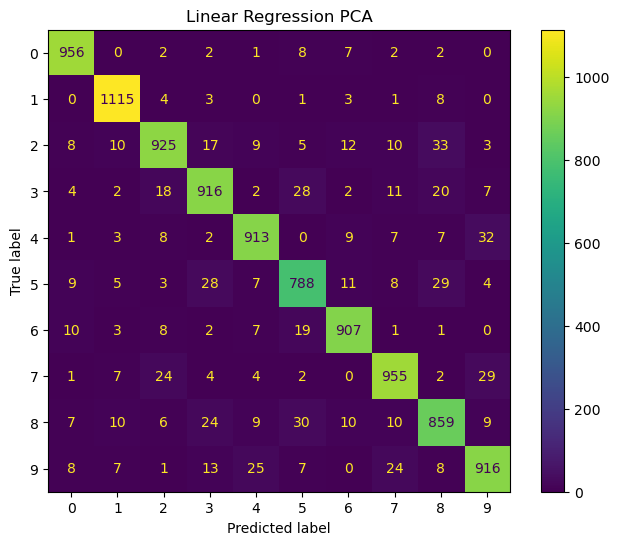

In [102]:
plot_conf_matrix(y_test, y_pred, lr)
plt.title('Linear Regression PCA')
plt.savefig('Images/cm_lr_pca.png')
plt.show()

In [19]:
#LDA transformed data
lr = LogisticRegression(n_jobs=-1)
lr.fit(x_train_lda, y_train)

print(lr.score(x_train_lda, y_train))
y_pred = lr.predict(x_test_lda)
print(accuracy_score(y_test, y_pred))

0.8907333333333334
0.8857


In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.96      0.95      1135
           2       0.90      0.86      0.88      1032
           3       0.87      0.87      0.87      1010
           4       0.87      0.91      0.89       982
           5       0.85      0.83      0.84       892
           6       0.91      0.92      0.92       958
           7       0.89      0.87      0.88      1028
           8       0.83      0.81      0.82       974
           9       0.85      0.84      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000



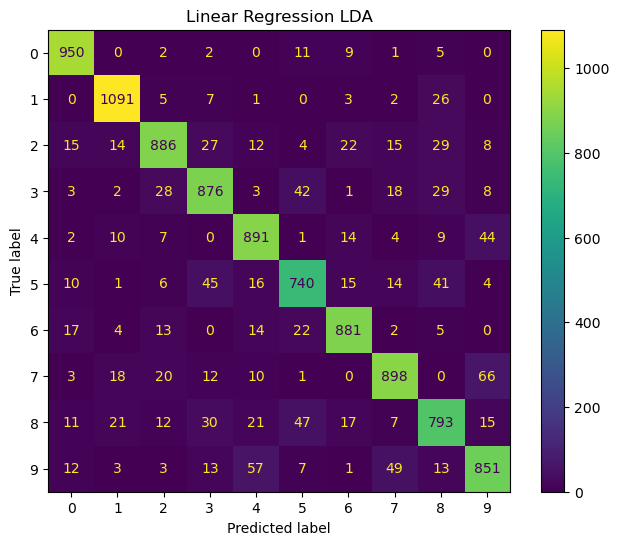

In [105]:
plot_conf_matrix(y_test, y_pred, lr)
plt.title('Linear Regression LDA')
plt.savefig('Images/cm_lr_lda.png')
plt.show()

In [106]:
#custom transformed data
lr = LogisticRegression(n_jobs=-1)
lr.fit(x_train_to_one, y_train)

print(lr.score(x_train_to_one, y_train))
y_pred = lr.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

0.9308166666666666
0.9242


In [107]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.90      0.92      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.86      0.89       892
           6       0.94      0.96      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.87      0.89      0.88       974
           9       0.90      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



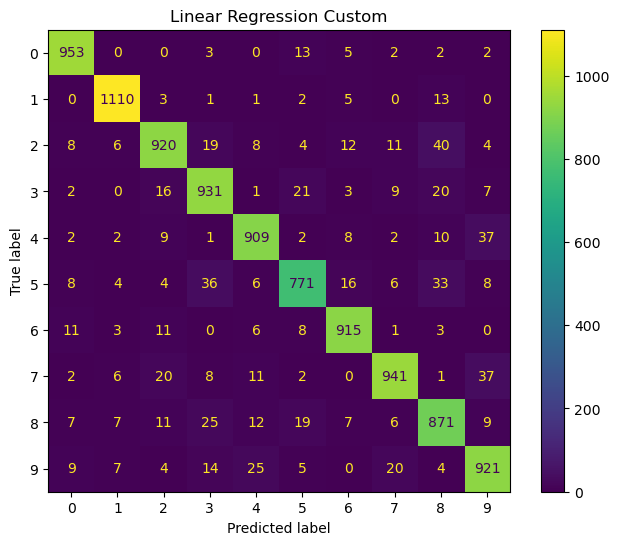

In [108]:
plot_conf_matrix(y_test, y_pred, lr)
plt.title('Linear Regression Custom')
plt.savefig('Images/cm_lr_custom.png')
plt.show()

<h3><b>Using Naive Bayes</b></h3>

In [109]:
#original data
gnb = GaussianNB()
gnb.fit(x_train, y_train)

print(gnb.score(x_train, y_train))
print(gnb.score(x_test, y_test))

0.5649
0.5558


In [110]:
#custom transformed data
gnb = GaussianNB()
gnb.fit(x_train_to_one, y_train)

print(gnb.score(x_train_to_one, y_train))
print(gnb.score(x_test_to_one, y_test))

0.5558333333333333
0.5484


In [111]:
#custom transformed data
mnb = MultinomialNB()
mnb.fit(x_train_to_one, y_train)

print(mnb.score(x_train_to_one, y_train))
print(mnb.score(x_test_to_one, y_test))

0.8103333333333333
0.8236


In [112]:
#original data
mnb = MultinomialNB()
mnb.fit(x_train, y_train)

print(mnb.score(x_train, y_train))
print(mnb.score(x_test, y_test))

0.8252833333333334
0.8365


<h3><b>Using Random Forest</b></h3>

In [113]:
#original data
rf_orig = RandomForestClassifier(n_estimators=200,
                            bootstrap=True,
                            oob_score=True,
                            max_samples=0.9,
                            n_jobs=12,
                            random_state=3)

rf_orig.fit(x_train_mean, y_train)

RandomForestClassifier(max_samples=0.9, n_estimators=200, n_jobs=12,
                       oob_score=True, random_state=3)

In [114]:
print(rf_orig.score(x_train_mean, y_train))
y_pred = rf_orig.predict(x_test_mean)
print(accuracy_score(y_test, y_pred))

1.0
0.9613


In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.97      0.97      0.97       982
           5       0.94      0.97      0.95       892
           6       0.98      0.96      0.97       958
           7       0.98      0.93      0.95      1028
           8       0.93      0.96      0.95       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



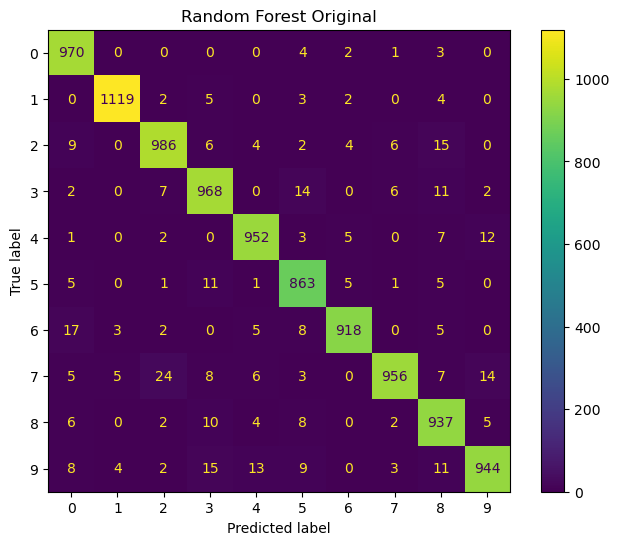

In [116]:
plot_conf_matrix(y_test, y_pred, rf_orig)
plt.title('Random Forest Original')
plt.savefig('Images/cm_rf_orig.png')
plt.show()

In [117]:
#custom transformed data
rf_custom = RandomForestClassifier(n_estimators=200,
                            bootstrap=True,
                            oob_score=True,
                            max_samples=0.9,
                            n_jobs=12,
                            random_state=3)

rf_custom.fit(x_train_to_one, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=12, oob_score=True,
                       random_state=3)

In [118]:
print(rf_custom.score(x_train_to_one, y_train))
y_pred = rf_custom.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

1.0
0.9718


In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



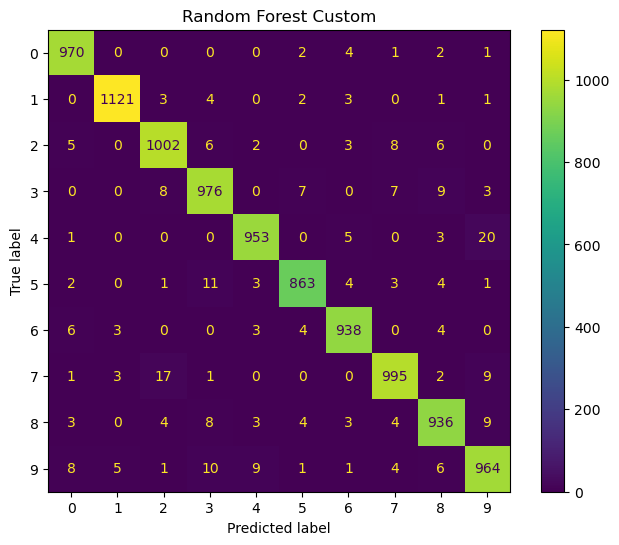

In [120]:
plot_conf_matrix(y_test, y_pred, rf_custom)
plt.title('Random Forest Custom')
plt.savefig('Images/cm_lr_custom.png')
plt.show()

<h3><b>Using AdaBoost with Decision Tree Stumps of max depth = 2</b></h3>

In [121]:
#original data
ada_orig_d2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                              learning_rate=0.5,
                              n_estimators=200,
                              algorithm='SAMME.R',
                              random_state=3)

ada_orig_d2.fit(x_train_mean, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=200, random_state=3)

In [122]:
print(ada_orig_d2.score(x_train_mean, y_train))
y_pred = ada_orig_d2.predict(x_test_mean)
print(accuracy_score(y_test, y_pred))

0.8604833333333334
0.6201


In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       980
           1       0.95      0.78      0.86      1135
           2       0.89      0.51      0.64      1032
           3       0.43      0.68      0.53      1010
           4       0.57      0.73      0.64       982
           5       0.49      0.91      0.63       892
           6       0.84      0.82      0.83       958
           7       0.00      0.00      0.00      1028
           8       0.45      0.87      0.59       974
           9       0.21      0.01      0.02      1009

    accuracy                           0.62     10000
   macro avg       0.57      0.63      0.57     10000
weighted avg       0.57      0.62      0.57     10000



c:\Anaconda\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


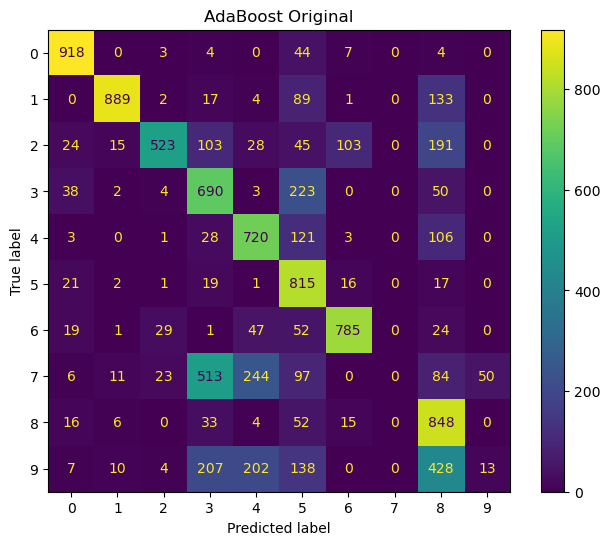

In [124]:
plot_conf_matrix(y_test, y_pred, ada_orig_d2)
plt.title('AdaBoost Original')
plt.savefig('Images/cm_ada_orig.png')
plt.show()

In [125]:
#custom transformed data
ada_custom_d2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                learning_rate=0.5,
                                n_estimators=200,
                                algorithm='SAMME.R',
                                random_state=3)

ada_custom_d2.fit(x_train_to_one, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=200, random_state=3)

In [126]:
print(ada_custom_d2.score(x_train_to_one, y_train))
y_pred = ada_custom_d2.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

0.85875
0.8542


In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       980
           1       0.93      0.98      0.96      1135
           2       0.90      0.69      0.78      1032
           3       0.87      0.85      0.86      1010
           4       0.86      0.89      0.87       982
           5       0.76      0.81      0.79       892
           6       0.80      0.93      0.86       958
           7       0.87      0.90      0.89      1028
           8       0.81      0.85      0.83       974
           9       0.83      0.79      0.81      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



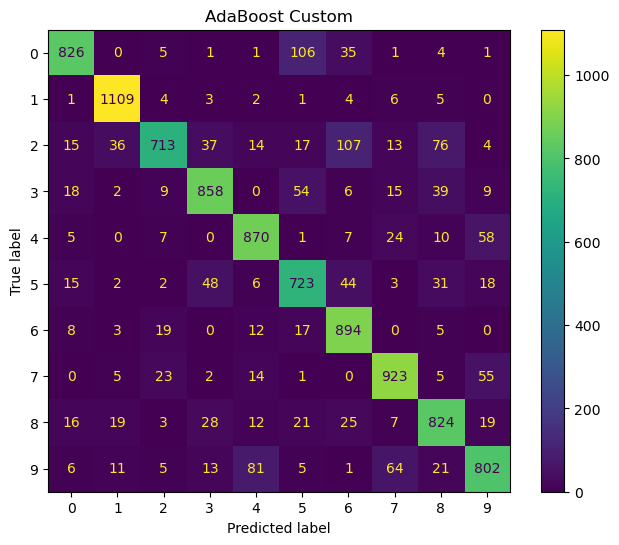

In [128]:
plot_conf_matrix(y_test, y_pred, ada_custom_d2)
plt.title('AdaBoost Custom')
plt.savefig('Images/cm_ada_custom.png')
plt.show()

<h3><b>Using Histogram Gradient Boosting Classifier</b></h3>

In [129]:
#original data
gbc_orig = HistGradientBoostingClassifier(loss='log_loss',
                                          learning_rate=0.1,
                                          max_iter=200,
                                          early_stopping=True,
                                          random_state=3)

gbc_orig.fit(x_train_mean, y_train)

HistGradientBoostingClassifier(early_stopping=True, max_iter=200,
                               random_state=3)

In [130]:
print(gbc_orig.score(x_train_mean, y_train))
y_pred = gbc_orig.predict(x_test_mean)
print(accuracy_score(y_test, y_pred))

0.9980333333333333
0.9452


In [131]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       1.00      0.94      0.97      1135
           2       0.96      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.93      0.98      0.96       982
           5       0.88      0.98      0.93       892
           6       1.00      0.80      0.89       958
           7       0.97      0.96      0.97      1028
           8       0.83      0.99      0.90       974
           9       1.00      0.87      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.94     10000
weighted avg       0.95      0.95      0.95     10000



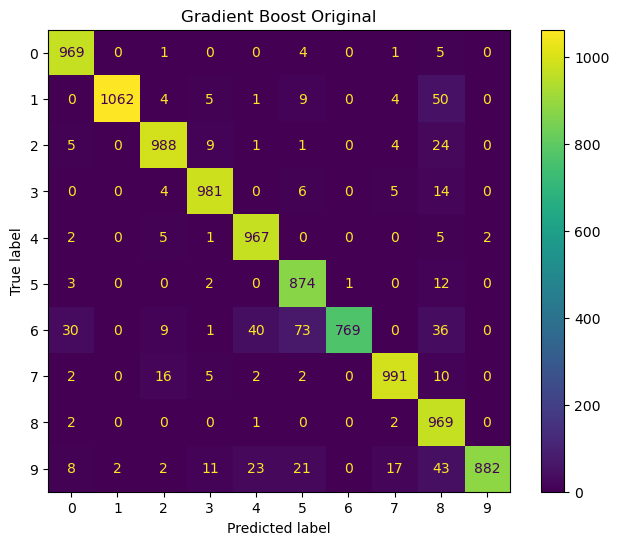

In [132]:
plot_conf_matrix(y_test, y_pred, gbc_orig)
plt.title('Gradient Boost Original')
plt.savefig('Images/cm_gb_orig.png')
plt.show()

In [133]:
#custom transformed data
gbc_custom = HistGradientBoostingClassifier(loss='log_loss',
                                          learning_rate=0.1,
                                          max_iter=200,
                                          early_stopping=True,
                                          random_state=3)

gbc_custom.fit(x_train_to_one, y_train)

HistGradientBoostingClassifier(early_stopping=True, max_iter=200,
                               random_state=3)

In [134]:
print(gbc_custom.score(x_train_to_one, y_train))
y_pred = gbc_custom.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

0.9980666666666667
0.9808


In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



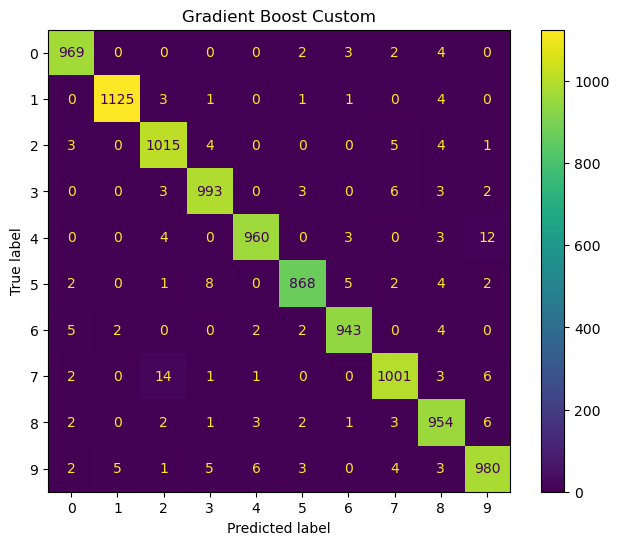

In [136]:
plot_conf_matrix(y_test, y_pred, gbc_custom)
plt.title('Gradient Boost Custom')
plt.savefig('Images/cm_gb_custom.png')
plt.show()

<h3><b>Using Soft Voting on the best 3 classifiers obtained as of now (VotingClassifier not used as we would have to fit the classifiers again, and that would have taken time</b></h3>

In [94]:
#custom transformed data
proba_rf = rf_custom.predict_proba(x_test_to_one)
proba_knn = knn_custom.predict_proba(x_test_to_one)
proba_gbc = gbc_custom.predict_proba(x_test_to_one)

In [95]:
sum_proba = proba_rf + proba_knn + proba_gbc

In [101]:
proba_test = np.argmax(sum_proba, axis=1)

In [102]:
accuracy_score(y_test, proba_test)

0.9806

<h3><b>Using Hard Voting on the best 3 classifiers obtained as of now (VotingClassifier not used as we would have to fit the classifiers again, and that would have taken time</b></h3>

In [103]:
#hard voting
pred_rf = rf_custom.predict(x_test_to_one)
pred_knn = knn_custom.predict(x_test_to_one)
pred_gbc = gbc_custom.predict(x_test_to_one)

In [104]:
all_pred = np.vstack((pred_rf, pred_knn, pred_gbc))
print(all_pred)

[[7 2 1 ... 4 5 6]
 [7 2 1 ... 4 5 6]
 [7 2 1 ... 4 5 6]]


In [105]:
majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_pred)

In [107]:
accuracy_score(y_test, majority_votes)

0.977

<h3><b>Using RBF Kernel SVM</b></h3>

In [ ]:
#original data
svc_orig = SVC(kernel='rbf', random_state=3)
svc_orig.fit(x_train_mean, y_train)

In [138]:
print(svc_orig.score(x_train_mean, y_train))
y_pred = gbc_custom.predict(x_test_mean)
print(accuracy_score(y_test, y_pred))

0.9866333333333334
0.9612


In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.96      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.97      0.97       982
           5       0.91      0.98      0.94       892
           6       0.99      0.96      0.98       958
           7       0.91      0.98      0.95      1028
           8       0.99      0.89      0.94       974
           9       0.98      0.90      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



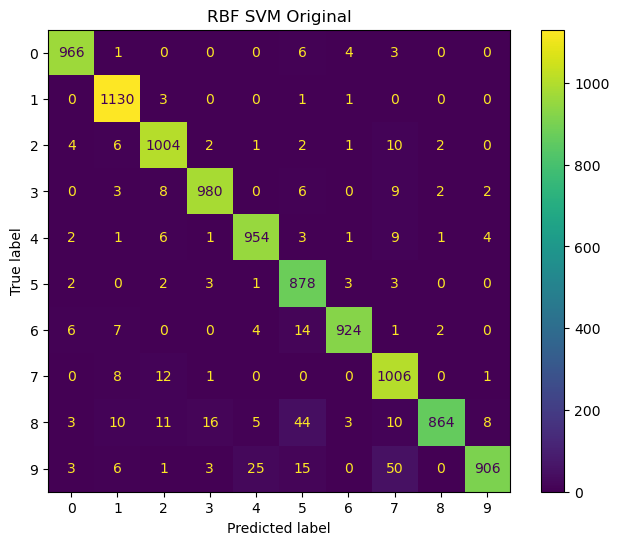

In [140]:
plot_conf_matrix(y_test, y_pred, svc_orig)
plt.title('RBF SVM Original')
plt.savefig('Images/cm_svm_orig.png')
plt.show()

In [ ]:
#custom transformed data
svc_custom = SVC(kernel='rbf', random_state=3)
svc_custom.fit(x_train_to_one, y_train)

In [142]:
print(svc_custom.score(x_train_to_one, y_train))
y_pred = svc_custom.predict(x_test_to_one)
print(accuracy_score(y_test, y_pred))

0.98875
0.9791


In [143]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



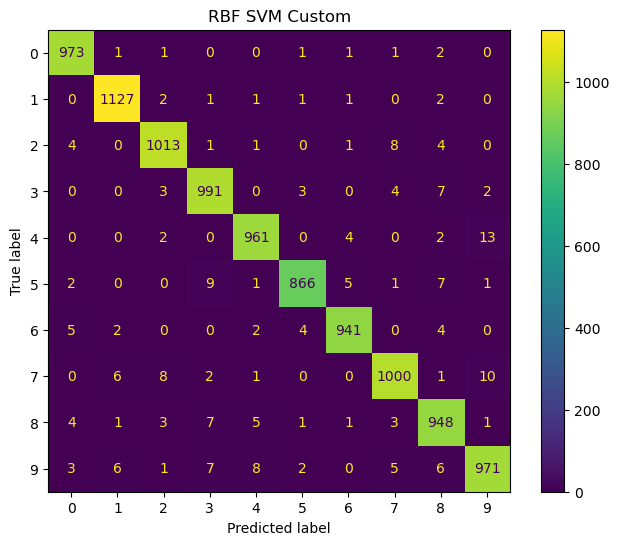

In [144]:
plot_conf_matrix(y_test, y_pred, svc_orig)
plt.title('RBF SVM Custom')
plt.savefig('Images/cm_svm_custom.png')
plt.show()